# 3주차: 오디오 파일 처리와 변환

## 학습 목표
- 오디오를 데이터로 변환하는 전체 파이프라인을 이해하자
- librosa로 오디오 파일을 읽고 처리하는 방법을 익히자
- 시간 도메인과 주파수 도메인 변환을 수행하자
- 오디오 특징을 추출하고 분석해보자

## 1. 디지털 오디오의 기초

디지털 오디오는 연속적인 아날로그 신호를 이산적인 디지털 데이터로 변환한 것이다. 이 과정에서 샘플링과 양자화가 일어난다.

샘플링 레이트(Sample Rate)는 1초당 측정하는 샘플의 개수를 의미한다. CD 품질은 44,100Hz(44.1kHz)를 사용한다.
비트 깊이(Bit Depth)는 각 샘플의 진폭을 표현하는 비트 수다. 16비트나 24비트가 일반적이다.
오디오 파일 형식에는 무손실(WAV, FLAC)과 손실(MP3, AAC) 압축 방식이 있다.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from scipy import signal
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print(f"Librosa 버전: {librosa.__version__}")
print("오디오 처리 라이브러리 로딩 완료!")

Librosa 버전: 0.11.0
오디오 처리 라이브러리 로딩 완료!


## 2. 테스트 오디오 신호 생성

### 2.1 기본 오디오 신호 생성

실제 오디오 파일을 다루기 전에, 수학적으로 정의된 신호를 생성하여 개념을 이해해보자.
사인파, 코사인파, 그리고 이들의 조합으로 복잡한 신호를 만들 수 있다.
이러한 기본 신호들은 푸리에 변환의 기초가 되며, 모든 복잡한 소리를 구성하는 기본 요소다.

In [5]:
# 샘플링 파라미터 설정
sample_rate = 22050  # 22.05 kHz (librosa 기본값)
duration = 3.0  # 3초
n_samples = int(sample_rate * duration)

# 시간 배열 생성
t = np.linspace(0, duration, n_samples, endpoint=False)

# 단일 주파수 신호 생성 (A4 음, 440Hz)
frequency_a4 = 440.0
amplitude = 0.5
sine_wave = amplitude * np.sin(2 * np.pi * frequency_a4 * t)

print(f"샘플링 레이트: {sample_rate} Hz")
print(f"신호 길이: {duration} 초")
print(f"총 샘플 수: {n_samples}")
print(f"신호 형태: {sine_wave.shape}")
print(f"신호 범위: [{sine_wave.min():.3f}, {sine_wave.max():.3f}]")

샘플링 레이트: 22050 Hz
신호 길이: 3.0 초
총 샘플 수: 66150
신호 형태: (66150,)
신호 범위: [-0.500, 0.500]


### 2.2 복합 신호 생성 (화음)

실제 음악은 여러 주파수가 합쳐진 복합 신호다.
화음은 여러 음이 동시에 울릴 때 생성되며, 각 음의 주파수 비율이 화음의 특성을 결정한다.
메이저 코드, 마이너 코드 등 다양한 화음을 수학적으로 생성할 수 있다.

In [ ]:
# C 메이저 코드 생성 (C, E, G)
c4_freq = 261.63  # C4
e4_freq = 329.63  # E4
g4_freq = 392.00  # G4

# 각 음 생성
c_note = 0.3 * np.sin(2 * np.pi * c4_freq * t)
e_note = 0.3 * np.sin(2 * np.pi * e4_freq * t)
g_note = 0.3 * np.sin(2 * np.pi * g4_freq * t)

# 화음 생성 (세 음을 합침)
c_major_chord = c_note + e_note + g_note

# 엔벨로프 적용 (페이드 인/아웃)
# Envelope: 시간에 따른 음량 변화를 제어하는 곡선
# - Attack: 소리가 시작되어 최대 음량에 도달하는 시간
# - Decay: 최대 음량에서 지속 음량으로 감소하는 시간
# - Sustain: 유지되는 음량 레벨
# - Release: 소리가 끝날 때 페이드 아웃되는 시간
envelope = np.ones_like(t)
fade_samples = int(0.1 * sample_rate)  # 0.1초 페이드
envelope[:fade_samples] = np.linspace(0, 1, fade_samples)  # Attack (fade in)
envelope[-fade_samples:] = np.linspace(1, 0, fade_samples)  # Release (fade out)

c_major_chord_envelope = c_major_chord * envelope

print("C Major Chord Generated")
print(f"Frequency composition: C4({c4_freq:.2f}Hz), E4({e4_freq:.2f}Hz), G4({g4_freq:.2f}Hz)")
print("\nEnvelope (엔벨로프)란?")
print("- 소리의 시간적 변화를 나타내는 곡선")
print("- 실제 악기는 즉시 최대 음량이 되지 않고 점진적으로 변화")
print("- ADSR: Attack, Decay, Sustain, Release의 약자")

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 처음 0.02초만 표시 (파형 구조 확인)
plot_samples = int(0.02 * sample_rate)

axes[0].plot(t[:plot_samples], c_major_chord[:plot_samples], 'b-', alpha=0.7)
axes[0].set_title('C Major Chord Waveform (First 20ms)')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Amplitude')

axes[1].plot(t, c_major_chord_envelope, 'g-', alpha=0.7)
axes[1].set_title('C Major Chord with Envelope (Full)')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

## 3. 오디오 파일 저장과 읽기

### 3.1 오디오 파일 저장

생성한 오디오 신호를 파일로 저장하면 다른 프로그램에서도 재생할 수 있다.
WAV 형식은 무손실 압축으로 원본 품질을 유지한다.
soundfile 라이브러리를 사용하면 다양한 오디오 형식을 지원한다.

In [7]:
# 임시 오디오 파일 저장
import tempfile
import os

# 임시 디렉토리 생성
temp_dir = tempfile.mkdtemp()
audio_file_path = os.path.join(temp_dir, 'test_audio.wav')

# 오디오 파일 저장
sf.write(audio_file_path, c_major_chord_envelope, sample_rate)
print(f"오디오 파일 저장: {audio_file_path}")

# 파일 정보 확인
file_info = sf.info(audio_file_path)
print(f"\n파일 정보:")
print(f"  - 샘플링 레이트: {file_info.samplerate} Hz")
print(f"  - 채널 수: {file_info.channels}")
print(f"  - 프레임 수: {file_info.frames}")
print(f"  - 길이: {file_info.duration:.2f} 초")
print(f"  - 형식: {file_info.format}")
print(f"  - 서브타입: {file_info.subtype}")

오디오 파일 저장: /tmp/tmpiqru6r27/test_audio.wav

파일 정보:
  - 샘플링 레이트: 22050 Hz
  - 채널 수: 1
  - 프레임 수: 66150
  - 길이: 3.00 초
  - 형식: WAV
  - 서브타입: PCM_16


### 3.2 Librosa로 오디오 파일 읽기

Librosa는 음악 정보 검색(MIR) 연구를 위한 파이썬 라이브러리다.
오디오 파일을 자동으로 모노로 변환하고 정규화한다.
다양한 오디오 분석 기능을 제공하여 음악 연구에 필수적이다.

In [10]:
# Librosa로 오디오 파일 읽기
y, sr = librosa.load(audio_file_path, sr=None)  # sr=None은 원본 샘플링 레이트 유지

print(f"Librosa로 읽은 오디오 정보:")
print(f"  - 신호 형태: {y.shape}")
print(f"  - 샘플링 레이트: {sr} Hz")
print(f"  - 길이: {len(y) / sr:.2f} 초")
print(f"  - 신호 범위: [{y.min():.3f}, {y.max():.3f}]")
print(f"  - RMS 에너지: {np.sqrt(np.mean(y**2)):.3f}")

# 스테레오 파일 읽기 (mono=False 옵션)
# 테스트를 위해 스테레오 파일 생성
stereo_signal = np.vstack([c_major_chord_envelope, sine_wave[:len(c_major_chord_envelope)]])
stereo_file_path = os.path.join(temp_dir, 'test_stereo.wav')
sf.write(stereo_file_path, stereo_signal.T, sample_rate)

y_stereo, sr_stereo = librosa.load(stereo_file_path, sr=None, mono=False)
print(f"\n스테레오 오디오 정보:")
print(f"  - 신호 형태: {y_stereo.shape}")
print(f"  - 채널 수: {y_stereo.shape[0] if y_stereo.ndim > 1 else 1}")

Librosa로 읽은 오디오 정보:
  - 신호 형태: (66150,)
  - 샘플링 레이트: 22050 Hz
  - 길이: 3.00 초
  - 신호 범위: [-0.899, 0.899]
  - RMS 에너지: 0.359

스테레오 오디오 정보:
  - 신호 형태: (2, 66150)
  - 채널 수: 2


## 4. 시간 도메인 분석

### 4.1 파형 시각화와 기본 특성

시간 도메인에서는 신호의 진폭이 시간에 따라 어떻게 변화하는지 관찰한다.
파형을 통해 음량 변화, 리듬 패턴, 무음 구간 등을 파악할 수 있다.
오디오 편집과 기본적인 신호 처리는 주로 시간 도메인에서 수행된다.

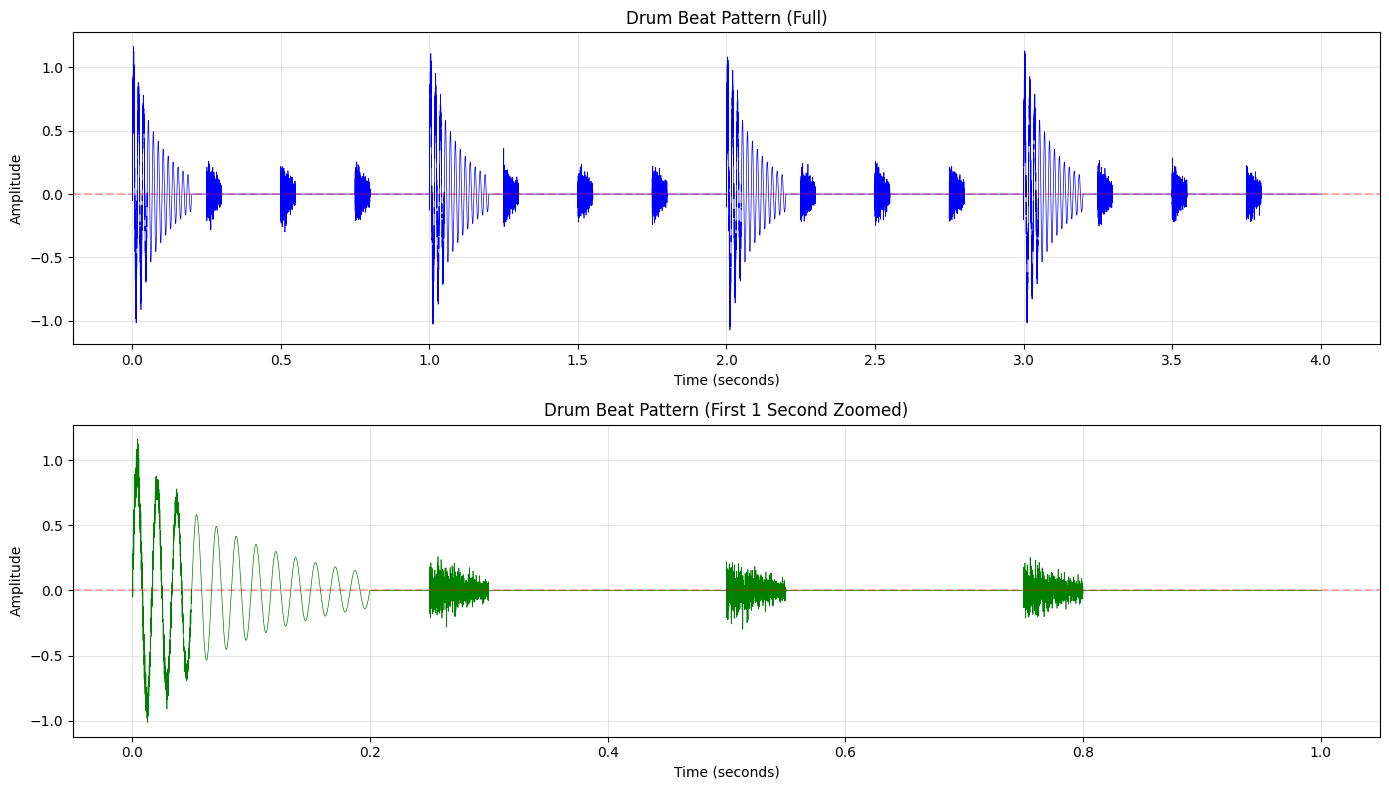

Signal Statistics:
  - Peak amplitude: 1.163
  - RMS: 0.159
  - Zero crossing rate: 0.076


In [16]:
# 더 복잡한 테스트 신호 생성 (드럼 비트 시뮬레이션)
beat_duration = 4.0
beat_sr = 22050
t_beat = np.linspace(0, beat_duration, int(beat_sr * beat_duration))

# 킥 드럼 시뮬레이션 (낮은 주파수 + 빠른 감쇠)
kick_times = [0, 1, 2, 3]  # 매 초마다 킥
drum_signal = np.zeros_like(t_beat)

for kick_time in kick_times:
    kick_start = int(kick_time * beat_sr)
    kick_duration = 0.2
    kick_samples = int(kick_duration * beat_sr)
    
    if kick_start + kick_samples < len(drum_signal):
        t_kick = np.linspace(0, kick_duration, kick_samples)
        kick = np.sin(2 * np.pi * 60 * t_kick) * np.exp(-10 * t_kick)
        drum_signal[kick_start:kick_start + kick_samples] += kick

# 하이햇 추가 (높은 주파수 노이즈)
hihat_times = np.arange(0, beat_duration, 0.25)  # 16분음표
for hihat_time in hihat_times:
    hihat_start = int(hihat_time * beat_sr)
    hihat_duration = 0.05
    hihat_samples = int(hihat_duration * beat_sr)
    
    if hihat_start + hihat_samples < len(drum_signal):
        hihat = np.random.randn(hihat_samples) * 0.1 * np.exp(-20 * np.linspace(0, hihat_duration, hihat_samples))
        drum_signal[hihat_start:hihat_start + hihat_samples] += hihat

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Full waveform
axes[0].plot(t_beat, drum_signal, 'b-', linewidth=0.5)
axes[0].set_title('Drum Beat Pattern (Full)')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Amplitude')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.3)

# First 1 second zoomed
zoom_samples = int(1.0 * beat_sr)
axes[1].plot(t_beat[:zoom_samples], drum_signal[:zoom_samples], 'g-', linewidth=0.5)
axes[1].set_title('Drum Beat Pattern (First 1 Second Zoomed)')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Amplitude')
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 기본 통계
print(f"Signal Statistics:")
print(f"  - Peak amplitude: {np.max(np.abs(drum_signal)):.3f}")
print(f"  - RMS: {np.sqrt(np.mean(drum_signal**2)):.3f}")
print(f"  - Zero crossing rate: {librosa.feature.zero_crossing_rate(drum_signal)[0].mean():.3f}")

### 4.2 시간 도메인 특징 추출

시간 도메인에서 추출할 수 있는 주요 특징들은 신호의 에너지 변화와 리듬 정보를 담고 있다.
RMS 에너지는 음량의 변화를, Zero Crossing Rate는 신호의 주파수 특성을 간접적으로 나타낸다.
이러한 특징들은 음악 장르 분류, 비트 검출 등에 활용된다.

In [ ]:
# RMS 에너지 계산
hop_length = 512
frame_length = 2048

rms = librosa.feature.rms(y=drum_signal, frame_length=frame_length, hop_length=hop_length)[0]
rms_time = librosa.frames_to_time(np.arange(len(rms)), sr=beat_sr, hop_length=hop_length)

# Zero Crossing Rate
zcr = librosa.feature.zero_crossing_rate(drum_signal, frame_length=frame_length, hop_length=hop_length)[0]

# Spectral Centroid (주파수 중심)
spectral_centroid = librosa.feature.spectral_centroid(y=drum_signal, sr=beat_sr, hop_length=hop_length)[0]

# 시각화
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Original signal
axes[0].plot(t_beat, drum_signal, 'b-', linewidth=0.5, alpha=0.7)
axes[0].set_title('Original Signal')
axes[0].set_ylabel('Amplitude')

# RMS Energy
axes[1].plot(rms_time, rms, 'r-', linewidth=2)
axes[1].set_title('RMS Energy')
axes[1].set_ylabel('RMS')
axes[1].fill_between(rms_time, 0, rms, alpha=0.3)

# Zero Crossing Rate
axes[2].plot(rms_time, zcr, 'g-', linewidth=2)
axes[2].set_title('Zero Crossing Rate')
axes[2].set_ylabel('ZCR')

# Spectral Centroid
axes[3].plot(rms_time, spectral_centroid, 'm-', linewidth=2)
axes[3].set_title('Spectral Centroid')
axes[3].set_xlabel('Time (seconds)')
axes[3].set_ylabel('Hz')

plt.tight_layout()
plt.show()

print(f"Feature Statistics:")
print(f"  - Mean RMS: {rms.mean():.4f}")
print(f"  - Mean ZCR: {zcr.mean():.4f}")
print(f"  - Mean Spectral Centroid: {spectral_centroid.mean():.2f} Hz")

## 5. 주파수 도메인 분석 (FFT)

### 5.1 푸리에 변환 기초

푸리에 변환(Fourier Transform)은 시간 도메인 신호를 주파수 도메인으로 변환한다.
모든 복잡한 신호는 여러 사인파의 합으로 표현될 수 있다는 원리에 기반한다.
FFT(Fast Fourier Transform)는 이산 푸리에 변환을 효율적으로 계산하는 알고리즘이다.

In [ ]:
# 테스트 신호 생성 (여러 주파수 성분)
test_duration = 1.0
test_sr = 8000  # 낮은 샘플링 레이트로 시각화 단순화
t_test = np.linspace(0, test_duration, int(test_sr * test_duration))

# 여러 주파수 성분을 가진 신호
freq_components = [
    (100, 1.0),   # 100Hz, 진폭 1.0
    (250, 0.5),   # 250Hz, 진폭 0.5
    (500, 0.3),   # 500Hz, 진폭 0.3
    (1000, 0.2)   # 1000Hz, 진폭 0.2
]

complex_signal = np.zeros_like(t_test)
for freq, amp in freq_components:
    complex_signal += amp * np.sin(2 * np.pi * freq * t_test)

# FFT 수행
n_fft = len(complex_signal)
fft_result = fft(complex_signal)
fft_freq = fftfreq(n_fft, 1/test_sr)[:n_fft//2]  # 양의 주파수만
fft_magnitude = np.abs(fft_result)[:n_fft//2] * 2/n_fft  # 정규화

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Time domain
axes[0].plot(t_test[:200], complex_signal[:200], 'b-')
axes[0].set_title('Time Domain Signal (First 200 Samples)')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

# Frequency domain
axes[1].plot(fft_freq, fft_magnitude, 'r-', linewidth=2)
axes[1].set_title('Frequency Domain (FFT Result)')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude')
axes[1].set_xlim([0, 1500])
axes[1].grid(True, alpha=0.3)

# 피크 주파수 표시
for freq, amp in freq_components:
    axes[1].axvline(x=freq, color='g', linestyle='--', alpha=0.5)
    axes[1].text(freq, amp*0.9, f'{freq}Hz', rotation=90, va='bottom')

plt.tight_layout()
plt.show()

# 피크 주파수 검출
peak_indices = signal.find_peaks(fft_magnitude, height=0.1)[0]
peak_frequencies = fft_freq[peak_indices]
peak_magnitudes = fft_magnitude[peak_indices]

print("Detected Frequency Components:")
for freq, mag in zip(peak_frequencies, peak_magnitudes):
    print(f"  - {freq:.1f} Hz: Magnitude {mag:.3f}")

### 5.2 STFT (Short-Time Fourier Transform)

STFT는 신호를 작은 시간 구간으로 나누어 각각에 FFT를 적용한다.
시간에 따른 주파수 변화를 관찰할 수 있어 음악 분석에 필수적이다.
스펙트로그램은 STFT 결과를 시각화한 것으로, 시간-주파수 표현을 제공한다.

In [ ]:
# 시간에 따라 변하는 신호 생성 (주파수 스윕)
sweep_duration = 3.0
sweep_sr = 22050
t_sweep = np.linspace(0, sweep_duration, int(sweep_sr * sweep_duration))

# Linear chirp (주파수가 선형적으로 증가)
f_start = 100
f_end = 2000
chirp_signal = signal.chirp(t_sweep, f_start, sweep_duration, f_end, method='linear')

# STFT 계산
n_fft = 2048
hop_length = 512
D = librosa.stft(chirp_signal, n_fft=n_fft, hop_length=hop_length)
D_magnitude = np.abs(D)
D_db = librosa.amplitude_to_db(D_magnitude, ref=np.max)

# 스펙트로그램 시각화
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Original signal
axes[0].plot(t_sweep, chirp_signal, 'b-', linewidth=0.5)
axes[0].set_title('Chirp Signal (Frequency Sweep)')
axes[0].set_ylabel('Amplitude')
axes[0].set_xlim([0, sweep_duration])

# Linear scale spectrogram
img1 = librosa.display.specshow(D_magnitude, y_axis='linear', x_axis='time',
                                sr=sweep_sr, hop_length=hop_length, ax=axes[1])
axes[1].set_title('Spectrogram (Linear Scale)')
axes[1].set_ylabel('Frequency (Hz)')
fig.colorbar(img1, ax=axes[1], format='%+2.0f')

# Log scale spectrogram (dB)
img2 = librosa.display.specshow(D_db, y_axis='log', x_axis='time',
                                sr=sweep_sr, hop_length=hop_length, ax=axes[2])
axes[2].set_title('Spectrogram (Log Scale, dB)')
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('Frequency (Hz)')
fig.colorbar(img2, ax=axes[2], format='%+2.0f dB')

plt.tight_layout()
plt.show()

print(f"STFT Results:")
print(f"  - STFT matrix shape: {D.shape}")
print(f"  - Number of frequency bins: {D.shape[0]}")
print(f"  - Number of time frames: {D.shape[1]}")
print(f"  - Frequency resolution: {sweep_sr/n_fft:.2f} Hz/bin")
print(f"  - Time resolution: {hop_length/sweep_sr*1000:.2f} ms/frame")

## 6. 오디오 특징 추출

### 6.1 MFCC (Mel-frequency Cepstral Coefficients)

MFCC는 음성 인식과 음악 정보 검색에서 가장 널리 사용되는 특징이다.
인간의 청각 시스템을 모방한 Mel 스케일을 사용하여 주파수를 변환한다.
음색(timbre) 정보를 효과적으로 표현하여 악기 분류, 장르 분류 등에 활용된다.

In [ ]:
# 음악적 신호 생성 (여러 악기 시뮬레이션)
music_duration = 2.0
music_sr = 22050
t_music = np.linspace(0, music_duration, int(music_sr * music_duration))

# 피아노 음 시뮬레이션 (기본음 + 하모닉스)
fundamental = 261.63  # C4
piano_signal = np.zeros_like(t_music)
harmonics = [1, 2, 3, 4, 5]  # 기본음과 배음들
harmonic_amplitudes = [1.0, 0.5, 0.3, 0.2, 0.1]

for h, amp in zip(harmonics, harmonic_amplitudes):
    piano_signal += amp * np.sin(2 * np.pi * fundamental * h * t_music)

# ADSR 엔벨로프 적용
envelope = np.ones_like(t_music)
attack_time = 0.01
decay_time = 0.1
sustain_level = 0.7
release_time = 0.3

attack_samples = int(attack_time * music_sr)
decay_samples = int(decay_time * music_sr)
release_samples = int(release_time * music_sr)

envelope[:attack_samples] = np.linspace(0, 1, attack_samples)
envelope[attack_samples:attack_samples+decay_samples] = np.linspace(1, sustain_level, decay_samples)
envelope[attack_samples+decay_samples:-release_samples] = sustain_level
envelope[-release_samples:] = np.linspace(sustain_level, 0, release_samples)

piano_signal = piano_signal * envelope

# MFCC 추출
n_mfcc = 13
mfccs = librosa.feature.mfcc(y=piano_signal, sr=music_sr, n_mfcc=n_mfcc)

# Delta MFCC (1차 미분)
mfccs_delta = librosa.feature.delta(mfccs)

# Delta-Delta MFCC (2차 미분)
mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

# 시각화
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Original signal
axes[0].plot(t_music[:1000], piano_signal[:1000], 'b-', linewidth=0.5)
axes[0].set_title('Piano Signal (First 1000 Samples)')
axes[0].set_ylabel('Amplitude')

# MFCC
img1 = librosa.display.specshow(mfccs, x_axis='time', sr=music_sr, ax=axes[1])
axes[1].set_title('MFCC')
axes[1].set_ylabel('MFCC Coefficients')
fig.colorbar(img1, ax=axes[1])

# Delta MFCC
img2 = librosa.display.specshow(mfccs_delta, x_axis='time', sr=music_sr, ax=axes[2])
axes[2].set_title('Delta MFCC (1st Derivative)')
axes[2].set_ylabel('MFCC Coefficients')
fig.colorbar(img2, ax=axes[2])

# Delta-Delta MFCC
img3 = librosa.display.specshow(mfccs_delta2, x_axis='time', sr=music_sr, ax=axes[3])
axes[3].set_title('Delta-Delta MFCC (2nd Derivative)')
axes[3].set_xlabel('Time (seconds)')
axes[3].set_ylabel('MFCC Coefficients')
fig.colorbar(img3, ax=axes[3])

plt.tight_layout()
plt.show()

print(f"MFCC Features:")
print(f"  - MFCC shape: {mfccs.shape}")
print(f"  - Number of coefficients: {n_mfcc}")
print(f"  - Number of time frames: {mfccs.shape[1]}")
print(f"  - Mean MFCC (per coefficient):")
for i in range(min(5, n_mfcc)):
    print(f"    MFCC[{i}]: {mfccs[i].mean():.3f}")

### 6.2 스펙트럴 특징 (Spectral Features)

스펙트럴 특징들은 주파수 도메인에서 추출되는 다양한 통계적 특성이다.
Spectral Centroid는 음색의 밝기를, Spectral Rolloff는 주파수 분포를 나타낸다.
이러한 특징들은 악기 인식, 음악 분류, 음질 평가 등에 활용된다.

In [ ]:
# 다양한 스펙트럴 특징 추출
# Spectral Centroid - 주파수 분포의 중심
spec_centroid = librosa.feature.spectral_centroid(y=piano_signal, sr=music_sr)[0]

# Spectral Bandwidth - 주파수 분포의 폭
spec_bandwidth = librosa.feature.spectral_bandwidth(y=piano_signal, sr=music_sr)[0]

# Spectral Rolloff - 에너지의 85%가 포함되는 주파수
spec_rolloff = librosa.feature.spectral_rolloff(y=piano_signal, sr=music_sr, roll_percent=0.85)[0]

# Spectral Contrast - 주파수 대역별 대비
spec_contrast = librosa.feature.spectral_contrast(y=piano_signal, sr=music_sr)

# Zero Crossing Rate
zcr = librosa.feature.zero_crossing_rate(piano_signal)[0]

# 시간 축 생성
frames = range(len(spec_centroid))
t_frames = librosa.frames_to_time(frames, sr=music_sr)

# 시각화
fig, axes = plt.subplots(5, 1, figsize=(14, 12))

# Spectral Centroid
axes[0].plot(t_frames, spec_centroid, 'b-', linewidth=2)
axes[0].set_title('Spectral Centroid')
axes[0].set_ylabel('Hz')
axes[0].fill_between(t_frames, 0, spec_centroid, alpha=0.3)

# Spectral Bandwidth
axes[1].plot(t_frames, spec_bandwidth, 'r-', linewidth=2)
axes[1].set_title('Spectral Bandwidth')
axes[1].set_ylabel('Hz')
axes[1].fill_between(t_frames, 0, spec_bandwidth, alpha=0.3)

# Spectral Rolloff
axes[2].plot(t_frames, spec_rolloff, 'g-', linewidth=2)
axes[2].set_title('Spectral Rolloff (85%)')
axes[2].set_ylabel('Hz')
axes[2].fill_between(t_frames, 0, spec_rolloff, alpha=0.3)

# Spectral Contrast
img = librosa.display.specshow(spec_contrast, x_axis='time', ax=axes[3])
axes[3].set_title('Spectral Contrast')
axes[3].set_ylabel('Frequency bands')
fig.colorbar(img, ax=axes[3])

# Zero Crossing Rate
axes[4].plot(t_frames, zcr, 'm-', linewidth=2)
axes[4].set_title('Zero Crossing Rate')
axes[4].set_xlabel('Time (seconds)')
axes[4].set_ylabel('Rate')

plt.tight_layout()
plt.show()

# 특징 통계
print("Spectral Feature Statistics:")
print(f"  - Spectral Centroid: {spec_centroid.mean():.2f} ± {spec_centroid.std():.2f} Hz")
print(f"  - Spectral Bandwidth: {spec_bandwidth.mean():.2f} ± {spec_bandwidth.std():.2f} Hz")
print(f"  - Spectral Rolloff: {spec_rolloff.mean():.2f} ± {spec_rolloff.std():.2f} Hz")
print(f"  - Zero Crossing Rate: {zcr.mean():.4f} ± {zcr.std():.4f}")

## 7. 고급 스펙트로그램 분석

### 7.1 Mel Spectrogram

Mel 스펙트로그램은 인간의 청각 특성을 반영한 주파수 표현이다.
저주파에서는 해상도가 높고, 고주파로 갈수록 해상도가 낮아진다.
음악 분류, 음성 인식 등 다양한 응용 분야에서 표준적으로 사용된다.

In [ ]:
# 복잡한 음악 신호 생성 (여러 음과 리듬)
complex_duration = 4.0
complex_sr = 22050
t_complex = np.linspace(0, complex_duration, int(complex_sr * complex_duration))

# 멜로디 라인 생성
melody_notes = [261.63, 293.66, 329.63, 349.23, 392.00, 349.23, 329.63, 293.66]  # C-D-E-F-G-F-E-D
note_duration = 0.5
melody_signal = np.zeros_like(t_complex)

for i, note_freq in enumerate(melody_notes):
    start_idx = int(i * note_duration * complex_sr)
    end_idx = int((i + 1) * note_duration * complex_sr)
    if end_idx <= len(melody_signal):
        t_note = np.linspace(0, note_duration, end_idx - start_idx)
        note_envelope = np.exp(-3 * t_note)  # 감쇠 엔벨로프
        melody_signal[start_idx:end_idx] = note_envelope * np.sin(2 * np.pi * note_freq * t_note)

# 베이스 라인 추가
bass_freq = 65.41  # C2
bass_signal = 0.3 * np.sin(2 * np.pi * bass_freq * t_complex)

# 전체 믹스
mixed_signal = melody_signal + bass_signal

# Mel spectrogram 계산
n_mels = 128
mel_spec = librosa.feature.melspectrogram(y=mixed_signal, sr=complex_sr, n_mels=n_mels)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# 일반 스펙트로그램과 비교
D_linear = librosa.stft(mixed_signal)
D_linear_db = librosa.amplitude_to_db(np.abs(D_linear), ref=np.max)

# 시각화
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Original signal
axes[0].plot(t_complex, mixed_signal, 'b-', linewidth=0.5)
axes[0].set_title('Music Signal (Melody + Bass)')
axes[0].set_ylabel('Amplitude')
axes[0].set_xlim([0, complex_duration])

# Linear spectrogram
img1 = librosa.display.specshow(D_linear_db, y_axis='linear', x_axis='time',
                                sr=complex_sr, ax=axes[1])
axes[1].set_title('Linear Frequency Spectrogram')
axes[1].set_ylabel('Frequency (Hz)')
fig.colorbar(img1, ax=axes[1], format='%+2.0f dB')

# Mel spectrogram
img2 = librosa.display.specshow(mel_spec_db, y_axis='mel', x_axis='time',
                                sr=complex_sr, ax=axes[2])
axes[2].set_title('Mel Spectrogram')
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('Mel Frequency')
fig.colorbar(img2, ax=axes[2], format='%+2.0f dB')

plt.tight_layout()
plt.show()

print(f"Mel Spectrogram Info:")
print(f"  - Shape: {mel_spec.shape}")
print(f"  - Number of Mel bands: {n_mels}")
print(f"  - Number of time frames: {mel_spec.shape[1]}")
print(f"  - Min value: {mel_spec_db.min():.2f} dB")
print(f"  - Max value: {mel_spec_db.max():.2f} dB")

### 7.2 Chroma Features

Chroma 특징은 음악의 화성 정보를 12개의 반음계로 표현한다.
옥타브와 무관하게 같은 음(C, C#, D, ...)을 하나의 클래스로 매핑한다.
코드 인식, 키 검출, 음악 유사도 측정 등에 활용된다.

In [ ]:
# Chroma 특징 추출
chroma_stft = librosa.feature.chroma_stft(y=mixed_signal, sr=complex_sr)
chroma_cqt = librosa.feature.chroma_cqt(y=mixed_signal, sr=complex_sr)
chroma_cens = librosa.feature.chroma_cens(y=mixed_signal, sr=complex_sr)

# 시각화
fig, axes = plt.subplots(3, 1, figsize=(14, 9))

# Chroma STFT
img1 = librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time',
                                sr=complex_sr, ax=axes[0])
axes[0].set_title('Chromagram (STFT-based)')
axes[0].set_ylabel('Pitch Class')
fig.colorbar(img1, ax=axes[0])

# Chroma CQT
img2 = librosa.display.specshow(chroma_cqt, y_axis='chroma', x_axis='time',
                                sr=complex_sr, ax=axes[1])
axes[1].set_title('Chromagram (CQT-based)')
axes[1].set_ylabel('Pitch Class')
fig.colorbar(img2, ax=axes[1])

# Chroma CENS
img3 = librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time',
                                sr=complex_sr, ax=axes[2])
axes[2].set_title('Chromagram (CENS)')
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('Pitch Class')
fig.colorbar(img3, ax=axes[2])

plt.tight_layout()
plt.show()

# 평균 Chroma 벡터 (전체 곡의 키 추정에 사용)
mean_chroma = chroma_stft.mean(axis=1)
pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

print("Mean Chroma Vector:")
for pc, val in zip(pitch_classes, mean_chroma):
    print(f"  {pc:2s}: {'█' * int(val * 20):<20s} {val:.3f}")

# 추정된 키
estimated_key_idx = np.argmax(mean_chroma)
print(f"\nEstimated Key: {pitch_classes[estimated_key_idx]}")

## 8. 실전 응용: 음원 특징 추출 파이프라인

### 8.1 종합 특징 추출 함수

실제 음원 분석 프로젝트에서는 여러 특징을 동시에 추출하여 사용한다.
각 특징은 음원의 다른 측면을 표현하므로, 조합하면 더 정확한 분석이 가능하다.
추출된 특징들은 머신러닝 모델의 입력으로 사용된다.

In [ ]:
def extract_audio_features(y, sr, n_mfcc=13, n_mels=128):
    """
    오디오 신호에서 다양한 특징을 추출하는 함수
    
    Parameters:
    -----------
    y : np.ndarray
        오디오 신호
    sr : int
        샘플링 레이트
    n_mfcc : int
        MFCC 계수 개수
    n_mels : int
        Mel 밴드 수
    
    Returns:
    --------
    features : dict
        추출된 특징들
    """
    
    features = {}
    
    # 시간 도메인 특징
    features['rms_mean'] = float(librosa.feature.rms(y=y).mean())
    features['rms_std'] = float(librosa.feature.rms(y=y).std())
    features['zcr_mean'] = float(librosa.feature.zero_crossing_rate(y).mean())
    features['zcr_std'] = float(librosa.feature.zero_crossing_rate(y).std())
    
    # 스펙트럴 특징
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spectral_centroid_mean'] = float(spec_cent.mean())
    features['spectral_centroid_std'] = float(spec_cent.std())
    
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['spectral_bandwidth_mean'] = float(spec_bw.mean())
    features['spectral_bandwidth_std'] = float(spec_bw.std())
    
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['spectral_rolloff_mean'] = float(spec_rolloff.mean())
    features['spectral_rolloff_std'] = float(spec_rolloff.std())
    
    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    for i in range(n_mfcc):
        features[f'mfcc_{i}_mean'] = float(mfccs[i].mean())
        features[f'mfcc_{i}_std'] = float(mfccs[i].std())
    
    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    for i in range(12):
        features[f'chroma_{i}_mean'] = float(chroma[i].mean())
    
    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = float(tempo)
    
    return features

# 테스트
features = extract_audio_features(mixed_signal, complex_sr)

# 특징 출력
print("추출된 오디오 특징:")
print("="*50)

# 카테고리별로 정리
time_features = {k: v for k, v in features.items() if 'rms' in k or 'zcr' in k}
spectral_features = {k: v for k, v in features.items() if 'spectral' in k}
mfcc_features = {k: v for k, v in features.items() if 'mfcc' in k}
chroma_features = {k: v for k, v in features.items() if 'chroma' in k}
rhythm_features = {k: v for k, v in features.items() if 'tempo' in k}

print("\n시간 도메인 특징:")
for k, v in time_features.items():
    print(f"  {k:25s}: {v:8.4f}")

print("\n스펙트럴 특징:")
for k, v in spectral_features.items():
    print(f"  {k:25s}: {v:8.2f}")

print("\n리듬 특징:")
for k, v in rhythm_features.items():
    print(f"  {k:25s}: {v:8.2f}")

print(f"\n총 특징 개수: {len(features)}")

### 8.2 특징 벡터를 활용한 음원 비교

추출된 특징 벡터를 사용하여 음원 간의 유사도를 계산할 수 있다.
유클리드 거리, 코사인 유사도 등 다양한 거리 측정 방법을 사용한다.
이는 음악 추천 시스템, 유사 음원 검색 등에 활용된다.

In [ ]:
# 여러 다른 신호 생성 및 특징 추출
signals = {}
all_features = {}

# 신호 1: 낮은 주파수 사인파
t_test = np.linspace(0, 1, complex_sr)
signals['Low_Sine'] = 0.5 * np.sin(2 * np.pi * 100 * t_test)

# 신호 2: 높은 주파수 사인파
signals['High_Sine'] = 0.5 * np.sin(2 * np.pi * 1000 * t_test)

# 신호 3: 화이트 노이즈
signals['White_Noise'] = np.random.randn(complex_sr) * 0.1

# 신호 4: 복합 신호 (여러 주파수)
signals['Complex'] = (0.3 * np.sin(2 * np.pi * 200 * t_test) + 
                      0.2 * np.sin(2 * np.pi * 400 * t_test) +
                      0.1 * np.sin(2 * np.pi * 800 * t_test))

# 각 신호의 특징 추출
for name, signal in signals.items():
    all_features[name] = extract_audio_features(signal, complex_sr)

# 특징 벡터로 변환 (선택된 특징만 사용)
selected_features = ['rms_mean', 'zcr_mean', 'spectral_centroid_mean', 
                    'spectral_bandwidth_mean', 'mfcc_0_mean', 'mfcc_1_mean']

feature_vectors = {}
for name, features in all_features.items():
    feature_vectors[name] = np.array([features[f] for f in selected_features])

# 유사도 행렬 계산
from scipy.spatial.distance import euclidean, cosine

signal_names = list(feature_vectors.keys())
n_signals = len(signal_names)

euclidean_distances = np.zeros((n_signals, n_signals))
cosine_similarities = np.zeros((n_signals, n_signals))

for i in range(n_signals):
    for j in range(n_signals):
        vec_i = feature_vectors[signal_names[i]]
        vec_j = feature_vectors[signal_names[j]]
        
        euclidean_distances[i, j] = euclidean(vec_i, vec_j)
        if i == j:
            cosine_similarities[i, j] = 1.0
        else:
            cosine_similarities[i, j] = 1 - cosine(vec_i, vec_j)

# 결과 출력
print("특징 벡터 비교:")
print("="*60)
print(f"사용된 특징: {selected_features}")
print()

# 특징 값 표시
feature_df = pd.DataFrame(feature_vectors).T
feature_df.columns = selected_features
print("특징 값:")
print(feature_df.round(3))
print()

# 유클리드 거리
distance_df = pd.DataFrame(euclidean_distances, 
                          index=signal_names, 
                          columns=signal_names)
print("\n유클리드 거리 행렬:")
print(distance_df.round(3))

# 코사인 유사도
similarity_df = pd.DataFrame(cosine_similarities,
                            index=signal_names,
                            columns=signal_names)
print("\n코사인 유사도 행렬:")
print(similarity_df.round(3))

# 가장 유사한 신호 쌍 찾기
np.fill_diagonal(euclidean_distances, np.inf)
min_dist_idx = np.unravel_index(euclidean_distances.argmin(), euclidean_distances.shape)
print(f"\n가장 유사한 신호 쌍: {signal_names[min_dist_idx[0]]} - {signal_names[min_dist_idx[1]]}")
print(f"유클리드 거리: {euclidean_distances[min_dist_idx]:.3f}")

## 9. 추천 실습

### 실습 1: 자신만의 오디오 신호 생성

다양한 악기 소리를 수학적으로 모델링해보자.
기본음과 배음의 조합, ADSR 엔벨로프를 활용하여 실제 악기와 유사한 소리를 만들어보자.
생성한 신호를 파일로 저장하고 실제로 들어보면서 차이를 비교해보자.

In [ ]:
# 실습 제안:
# 1. 플루트 소리 생성 (순수한 사인파 + 약간의 노이즈)
# 2. 기타 소리 생성 (플럭 엔벨로프 + 풍부한 배음)
# 3. 드럼 소리 생성 (짧은 버스트 + 노이즈)
# 4. 신시사이저 소리 (다양한 파형의 조합)
# 5. 각 소리의 스펙트로그램을 비교하여 특성 분석

### 실습 2: 실제 음원 파일 분석

자신이 좋아하는 음악 파일을 분석해보자.
다양한 특징을 추출하고 시각화하여 음악의 구조를 이해해보자.
여러 장르의 음악을 비교하여 각 장르의 특성을 파악해보자.

In [ ]:
# 실습 제안:
# 1. MP3/WAV 파일을 librosa로 로드
# 2. 전체 곡의 스펙트로그램 생성
# 3. 구간별 에너지 변화 분석 (intro, verse, chorus 구분)
# 4. 템포와 비트 검출
# 5. 주요 음정(key) 추정
# 6. 특징 벡터를 추출하여 유사한 곡 찾기

### 심화 학습을 위한 제안

더 깊이 있는 학습을 원한다면 다음 주제들을 탐구해보자:

1. **고급 신호처리 기법**: 웨이블릿 변환, 힐버트 변환, 적응 필터링
2. **음원 분리**: NMF, ICA를 활용한 소스 분리
3. **오디오 효과**: 리버브, 딜레이, 코러스 등 DSP 효과 구현
4. **실시간 처리**: 스트리밍 오디오 처리, 레이턴시 최적화
5. **딥러닝 응용**: CNN을 활용한 음원 분류, RNN을 활용한 음악 생성

이러한 기술들은 음악 정보 검색, 오디오 엔지니어링, 음악 제작 등 다양한 분야에서 활용된다.

In [ ]:
# 임시 파일 정리
import shutil
if 'temp_dir' in locals():
    shutil.rmtree(temp_dir)
    print("임시 파일 정리 완료")